In [5]:
# Multi class CLassification

# Embedding : Gensim Doc2Vec EMbedding
# ALgorithm : Logistic Regression

# How Embedding works

# Step 1: Clean The data (Lower; stop word removeval;tags replace;)
# Step 2: Split sentence and Create  taggeddocument 
#       Ex : TaggedDocument(words=['false', 'statements', 'or', 'representation'], tags=['Debt collection'])
# Step 3: Building Doc2Vec
#             -  Distributed Bag of Words (DBOW)
#             -  Distributed Memory (DM)
# Step 4: Build Final Vector Feature for the Classifier by unzipping target values and encoded vales for input data from model(gensim)
# Step 5: Train Model using Losgitic Regression

# Note : Here we have builtmodel using different types alogorithms in gensim (DBOW) and (DM) also clubbing or by merging both

In [ ]:
import pandas as pd

data = pd.read_csv("C:\MyWork\MyLearning\Career Growth\ML\Files\DataSet\Consumer Complaint.csv")

data = data[['Product','Issue']]

In [6]:
data = data[pd.notnull(data['Issue'])]

In [11]:
# No null values
data.isnull().sum()

Product    0
Issue      0
dtype: int64

In [12]:
data.head()

,Product,Issue
0,Debt collection,Communication tactics
1,Debt collection,Cont'd attempts collect debt not owed
2,Mortgage,"Application, originator, mortgage broker"
3,Credit card,Other
4,Debt collection,Cont'd attempts collect debt not owed


In [13]:
data.shape

(28154, 2)

In [14]:
data['Issue'].apply(lambda x: len(x.split(' '))).sum()

122193

In [15]:
# We have over 122193 words, it is a relatively large data set.

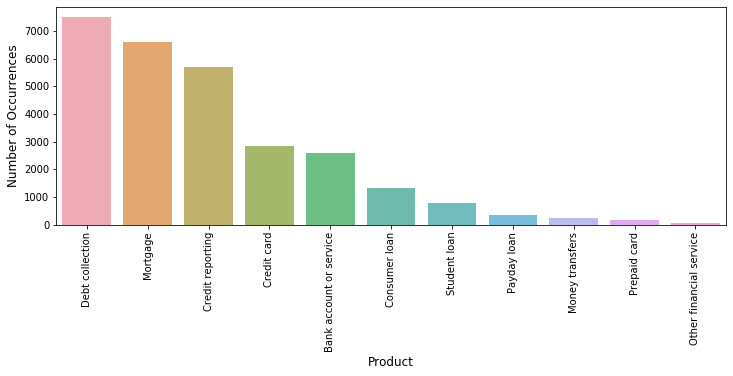

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

cnt_pro = data['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [28]:
# Lets look at the 'Issue' and Associated 'Product'

def print_compaints(index):
    
    column_values = data [data.index == index][['Product','Issue']].values[0]

    print("Issue:",column_values[0])
    print("Product:",column_values[1])
    

In [30]:
print_compaints(10)

Issue: Debt collection
Product: False statements or representation


In [36]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [37]:
data.head(3)

,Product,Issue
0,Debt collection,Communication tactics
1,Debt collection,Cont'd attempts collect debt not owed
2,Mortgage,"Application, originator, mortgage broker"


In [38]:
data['Issue'] = data['Issue'].apply(cleanText)

In [39]:
data.head()

,Product,Issue
0,Debt collection,communication tactics
1,Debt collection,cont'd attempts collect debt not owed
2,Mortgage,"application, originator, mortgage broker"
3,Credit card,other
4,Debt collection,cont'd attempts collect debt not owed


In [41]:
# Split data into train and test

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

train.shape

(19707, 2)

In [46]:
import nltk
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [48]:
# Train the Doc2Vec 
# In order to train the model, we need the tagged document which can be created by using models.doc2vec.TaggedDcument()

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Issue']), tags=[r.Product]), axis=1)

In [51]:
train_tagged[10]

TaggedDocument(words=['false', 'statements', 'or', 'representation'], tags=['Debt collection'])

In [53]:
test_tagged = test.apply( lambda r: TaggedDocument(words=tokenize_text(r['Issue']), tags=[r.Product]), axis=1)

In [56]:
test_tagged[5160]

TaggedDocument(words=['cont', "'d", 'attempts', 'collect', 'debt', 'not', 'owed'], tags=['Debt collection'])

In [57]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [60]:
# Word2Vec : Building Distributed Bag of Words (DBOW)
# Building a Vocabulary

# If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used
# 300- dimensional feature vectors.
# min_count=2, ignores all words with total frequency lower than this.
# negative=5 , specifies how many “noise words” should be drawn
# hs=0 , and negative is non-zero, negative sampling will be used.
# sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled
# workers=cores , use these many worker threads to train the model (=faster training with multicore machines)

from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 19707/19707 [00:00<00:00, 1628616.02it/s]


In [63]:

# Building Distributed Bag of Words (DBOW)
# Training a doc2vec model is rather straight-forward in Gensim, we initialize the model and train for 30 epochs.

from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████| 19707/19707 [00:00<00:00, 817659.01it/s]


In [68]:
# Building the Final Vector Feature for the Classifier

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [69]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [81]:
train_tagged[:1].values[0]

TaggedDocument(words=['incorrect', 'information', 'on', 'credit', 'report'], tags=['Credit reporting'])

In [82]:
X_train[:1]

(array([-4.11707163e-03, -3.35101113e-02,  1.89794287e-01,  1.33210674e-01,
        -5.08054376e-01, -2.15626284e-01, -8.44884813e-02, -2.26897970e-01,
        -1.52584180e-01, -1.50820851e-01, -1.66513994e-01,  1.61644846e-01,
         5.73121868e-02,  7.80496970e-02,  3.53914350e-02, -2.07831711e-01,
         2.62558274e-02, -1.07675426e-01, -1.93543330e-01, -1.20990679e-01,
        -3.58578749e-03,  9.37103108e-02, -6.00408204e-02,  4.78244096e-01,
         4.34925139e-01,  3.50125104e-01,  2.95598917e-02, -2.68027544e-01,
         7.17263967e-02, -9.85541791e-02,  6.58692047e-02,  5.49423173e-02,
        -1.30152553e-01, -1.03839234e-01,  2.59279162e-02, -1.67078435e-01,
        -6.82538673e-02,  1.42046049e-01, -6.01838119e-02, -9.38142985e-02,
         4.97903340e-02,  1.98072940e-02, -2.30624065e-01, -6.09951541e-02,
         6.35908395e-02, -1.18210085e-01,  1.58235639e-01,  1.33410975e-01,
        -2.06009790e-01, -5.07132374e-02, -6.69877604e-02,  1.40011922e-01,
        -1.9

In [84]:
y_train[:1]

('Credit reporting',)

In [86]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


c:\users\insakum46\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\insakum46\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.9952645909790458
Testing F1 score: 0.9951904401564695


In [88]:
# Word2Vec : Building Distributed Memory (DM)

model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 19707/19707 [00:00<00:00, 1480461.90it/s]


In [89]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████████████████████████████████| 19707/19707 [00:00<00:00, 1430623.76it/s]


Wall time: 40.7 s


In [ ]:
# Train the Logistic Regression Classifier

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [95]:
# Model Pairing: Few told combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) 
# improves performance.

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)



In [97]:
# Concatenate two models

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [98]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [99]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

c:\users\insakum46\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\insakum46\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.9932520421451403
Testing F1 score: 0.9931010347025356


In [107]:
logreg.predict(X_test[:10])

array(['Bank account or service', 'Debt collection',
       'Bank account or service', 'Debt collection', 'Debt collection',
       'Debt collection', 'Payday loan', 'Mortgage', 'Credit reporting',
       'Debt collection'], dtype='<U23')